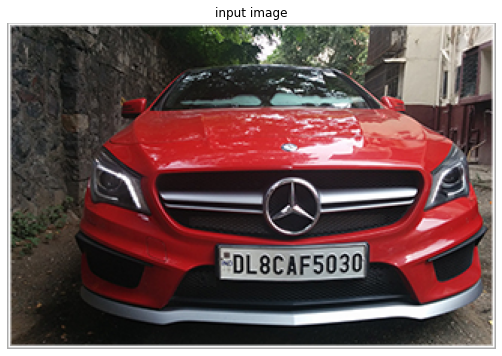

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('./car.jpg')
display(img, 'input image')
  

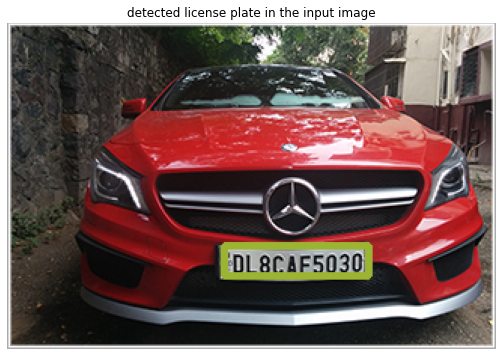

In [12]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

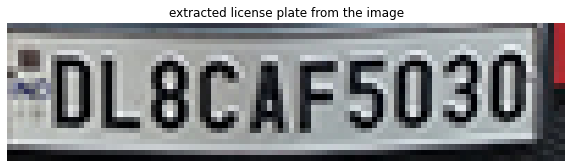

In [13]:
display(plate, 'extracted license plate from the image')

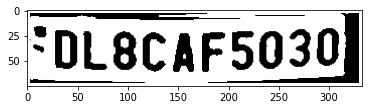

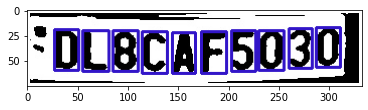

In [14]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res
  # Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

  # Let's see the segmented characters
char = segment_characters(plate)

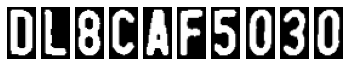

In [15]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [16]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = './data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [17]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [18]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same', name = 'conv2d_1'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same', name = 'conv2d_2'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same', name = 'conv2d_3'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same', name = 'conv2d_4'))
model.add(MaxPooling2D(pool_size=(4, 4),name = 'maxpool_1'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
864/864 [==============================] - 37s 6ms/step - loss: 3.1796 - custom_f1score: 0.1111 - val_loss: 2.1326 - val_custom_f1score: 0.4360
Epoch 2/80
864/864 [==============================] - 5s 6ms/step - loss: 1.3864 - custom_f1score: 0.6042 - val_loss: 0.8481 - val_custom_f1score: 0.7619
Epoch 3/80
864/864 [==============================] - 5s 6ms/step - loss: 0.6856 - custom_f1score: 0.7986 - val_loss: 0.6527 - val_custom_f1score: 0.8036
Epoch 4/80
864/864 [==============================] - 5s 6ms/step - loss: 0.4086 - custom_f1score: 0.8657 - val_loss: 0.3421 - val_custom_f1score: 0.9048
Epoch 5/80
864/864 [==============================] - 5s 6ms/step - loss: 0.3302 - custom_f1score: 0.8981 - val_loss: 0.2813 - val_custom_f1score: 0.9107
Epoch 6/80
864/864 [==============================] - 5s 6ms/step - loss: 0.2903 - custom_f1score: 0.9120 - val_loss: 0.3722 - val_custom_f1score: 0.8720
Epoch 7/80
864/864 [==============================] - 5s 6ms/step - loss: 0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


9L8CAF5030


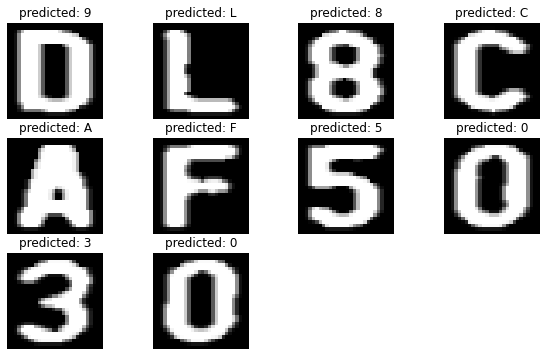

In [20]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

Visualizing CNN Layer Outputs

In [38]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 28, 28, 3)
	# center pixel data
	img = img.astype('float32')
	#img = img - [123.68, 116.779, 103.939]
	return img

In [39]:
car_img = load_image('./car.jpg')

In [37]:
import keras
layer_cnt = 5
layer_names = [layer.name for layer in model.layers[:layer_cnt]]
layer_outputs = [layer.output for layer in model.layers[:layer_cnt]]
activation_model = keras.models.Model(inputs=model.input,outputs=layer_outputs)
img_tensor = car_img #X_test[:1]
activations = activation_model.predict(img_tensor)

16


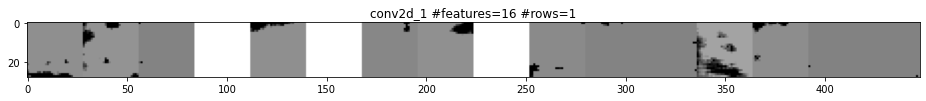

32


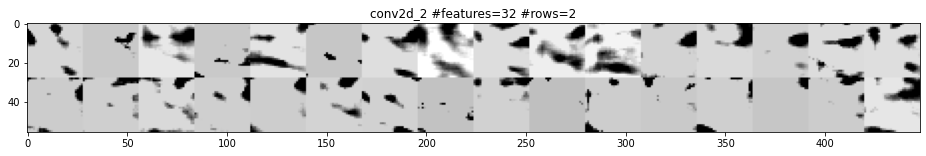

64


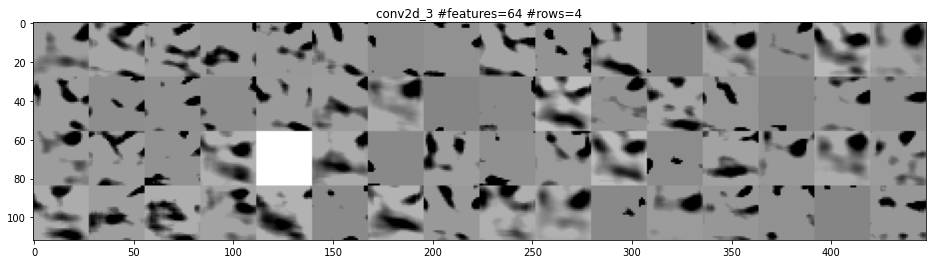

64


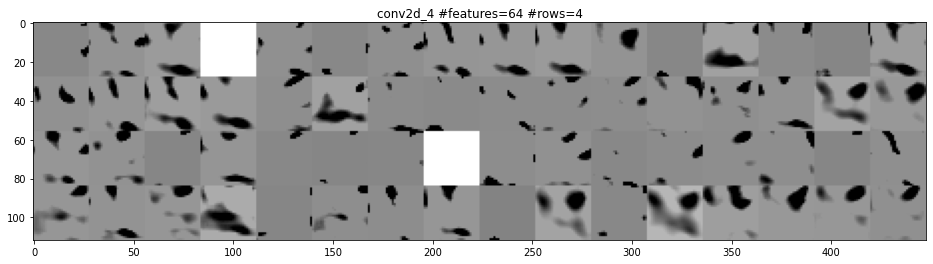

64


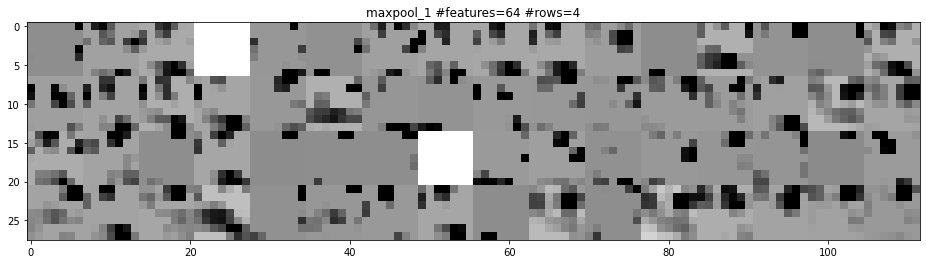

In [71]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  # This is the number of features in the feature map
  n_features = layer_activation.shape[-1]
  print(n_features)
  # The feature map has shape (1, size, size, n_features)
  size = layer_activation.shape[1]
  # We will tile the activation channels in this matrix
  n_cols = n_features // images_per_row
  # ksaehwa 실제 의미로 n_cols와 n_rows가 반대임 (변수명을 잘 못 지은 듯..)
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  # We'll tile each filter into this big horizontal grid
  for col in range(n_cols): # ksaehwa col은 사실 row임
    for row in range(images_per_row): # ksaehwa row는 사실 col임
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      # Post-process the feature to make it visually palatable
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
  # Display the grid
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name + " #features=" + str(n_features) + " #rows=" +str(n_cols))
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap = 'binary')
  plt.show()

Visualizing CNN Filters

In [58]:
  def generate_pattern(layer_name, filter_index, size=28): # ksaehwa org: size=150
    # Define the size and produce a random grey image with some noise,
    # then cast it to a tensor of float32
    img_tensor = np.random.random((1, size, size, 3)) * 20 + 128.
    #img_tensor = np.random.random((1, size, size, 1)) * 20 + 128. # ksaehwa
    img_tensor = tf.Variable(tf.cast(img_tensor, tf.float32))
    conv_layer = model.get_layer(layer_name)
    step_size = 1
    # Create a connection between the input and the target layer
    submodel = keras.models.Model([model.inputs[0]], [conv_layer.output])
    # Run gradient ascent for 40 steps
    for _ in range(40):
        with tf.GradientTape() as tape:
            outputs = submodel(img_tensor)
            loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
            # ksaehwa 사실 이 loss_value는 convolutional layer output의 의미 (전혀 loss가 아님)
        grads = tape.gradient(loss_value, img_tensor)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        img_tensor.assign_add(normalized_grads * step_size)
    # Convert input data to the valid range for imshow with RGB data ([0..255] for integers)
    img = img_tensor[0].numpy().astype(np.uint8)
    return img
    #return img[:,:,0] # ksaehwa

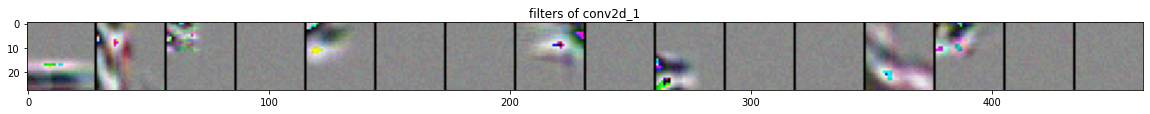

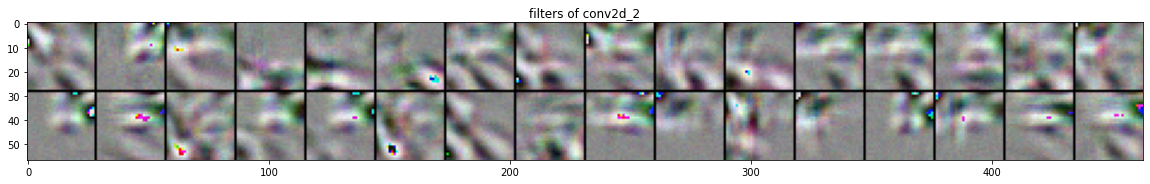

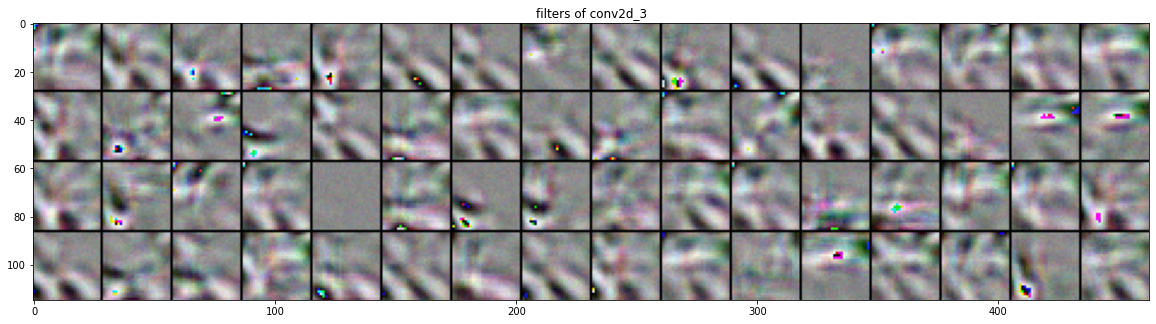

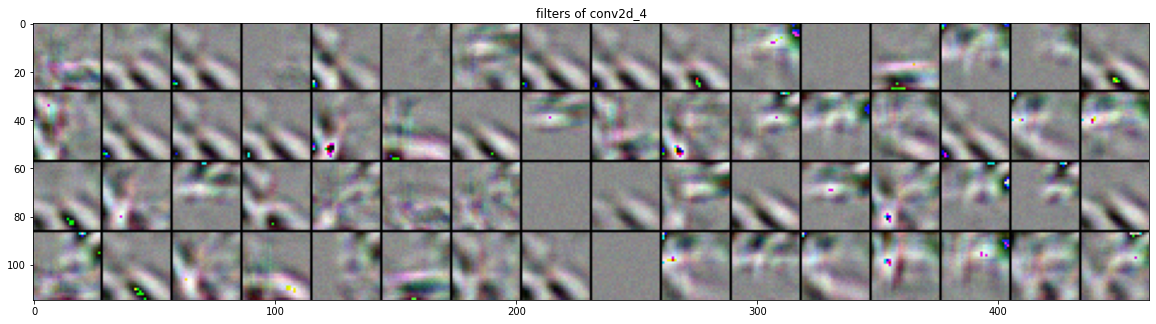

In [78]:
#for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
size = 28
n_features = 8
for k in range(4): # ksaehwa
    layer_name = 'conv2d_'+str(k+1) # ksaehwa
    column_cnt =  16 # ksaehwa
    row_cnt = model.get_layer(layer_name).output.shape[-1]//column_cnt # ksaehwa
    margin = 1 #ksaehwa # org 5
    # This an empty (black) image where we will store our results.
    #results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)).astype(np.uint8)
    results = np.zeros((row_cnt * size + (row_cnt-1) * margin,
column_cnt * size + (column_cnt-1) * margin, 3)).astype(np.uint8) 
    for i in range(row_cnt): #range(8): ksaehwa # iterate over the rows of our results grid
        for j in range(column_cnt): #range(8): ksaehwa # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            #filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            filter_img = generate_pattern(layer_name, i*column_cnt + j, size=size) # ksaehwa
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
            #results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img # ksaehwa
    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.title('filters of '+layer_name) # ksaehwa
    plt.imshow(results, cmap='binary') # ksaehwa
    plt.show()

Visualizing Class Activation Map

In [82]:
img_1 = load_image('./1.jpg')
img_6 = load_image('./6.jpg')
E_img = load_image('./E.jpg')

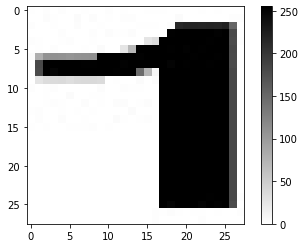

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


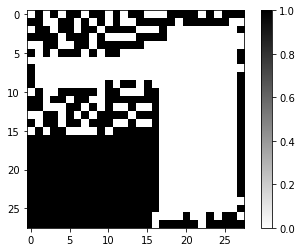

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(3, 36), dtype=float32)


In [105]:
from keras.preprocessing import image # ksaehwa
testImgIdx = 0 # ksaehwa
#x = X_test[2:3] # ksaehwa trouser: it should not be [2] due to shape
#x = X_test[testImgIdx:testImgIdx+1] # ksaehwa
x = np.ndarray(shape = (3,28,28,3))
x[0] = img_1
x[1] = img_6
x[2] = E_img
plt.imshow(x[0][:, :, 0], cmap='binary')
plt.colorbar()
plt.show() # ksaehwa

X_test_org = x[:] # ksaehwa
plt.imshow(X_test_org[testImgIdx],  cmap='binary')
plt.colorbar()
plt.show()

import cv2 
#TROUSER_IDX, ANKLE_BOOT_IDX, PULLOVER_IDX = 1, 9, 2 # ksaehwa
#testImgIdx2TargetIdx = [ANKLE_BOOT_IDX, PULLOVER_IDX, TROUSER_IDX] # ksaehwa
testImgIdx2TargetIdx = [1, 6, 'E']
last_conv_layer = model.get_layer('conv2d_3') # ksaehwa
# Construct the gradient model by supplying:
# (1) the inputs to our pre-trained model;
# (2) the output of the last convolutional layer in the network;
# (3) the output of the softmax activations from the model
grad_model = keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
# Set up GradientTape for automatic differentiation
with tf.GradientTape() as tape:
    # pass the image through the gradient model, and grab the loss associated with the specific class index
    conv_outputs, predictions = grad_model(x) # shape:(1, 7, 7, 256), (1, 10)
    print(predictions)
    #loss = predictions[:, TROUSER_IDX] # ksaehwa
    loss = predictions[:, testImgIdx2TargetIdx[testImgIdx]] # ksaehwa 사실 loss 변수는 1-loss의 의미
# loss == tf.Tensor([0.9999827], shape=(1,), dtype=float32)
# Compute the gradients of the "African elephant" class with regards to the output
# feature map of block5_conv3, given a sample image
grads = tape.gradient(loss, conv_outputs)[0] # shape == (7, 7, 256) #
# Vector of shape (256[ksaehwa]), where each entry is the mean intensity of the gradient over a specific feature map channel
weights = tf.reduce_mean(grads, axis=(0, 1)) # shape == (256,)
# Multiplies each channel in feature-map array by "how important this channel is" with regards to the class.
cam = tf.multiply(weights, conv_outputs[0]) # shape == (256,) * (7, 7, 256)  (7, 7, 256)
# The channel-wise mean of the resulting feature map is the heatmap of the class activation!
heatmap = tf.reduce_mean(cam, axis=-1).numpy() # shape == (7, 7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


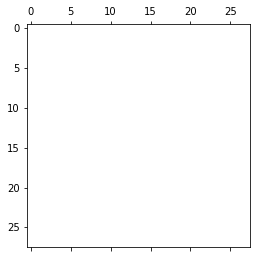

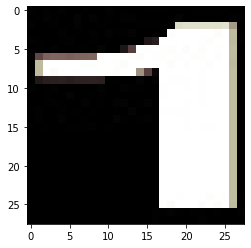

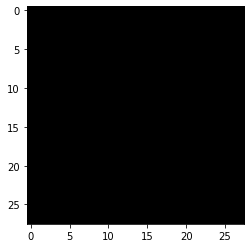

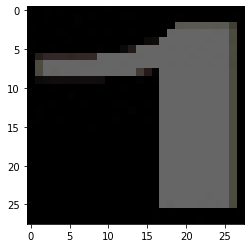

In [106]:
# #### Visualize the heatmap
# Postprocessing heatmap
heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())
plt.matshow(heatmap)
plt.show()

# #### Generate superimposed original image over the heatmap
# Use cv2 to load the original image
#cv_img = cv2.imread(IMG_PATH)
cv_img = X_test_org[testImgIdx] # ksaehwa
# Resize the heatmap to be the same as the original image
heatmap = cv2.resize(heatmap, (cv_img.shape[1], cv_img.shape[0]))
# Converts heatmap to RGB
heatmap = (heatmap * 255).astype(np.uint8)
cv_img = (cv_img).astype(np.uint8) # ksaehwa
cv_img = cv2.applyColorMap(cv_img, cv2.COLORMAP_BONE) # ksaehwa
plt.imshow(cv_img)
plt.show()
# Apply a color map to the heatmap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) # ksaehwa
plt.imshow(heatmap)
plt.show()
# Applies the heatmap to the original image.
# The variable alpha is a heatmap intensity factor
alpha = 0.4
output_image = cv2.addWeighted(cv_img, alpha, heatmap, 1 - alpha, 0)
plt.imshow(output_image)
plt.show()

In [107]:
!zip test.zip ./*

  adding: 1.jpg (deflated 17%)
  adding: 6.jpg (deflated 11%)
  adding: car.jpg (deflated 1%)
  adding: CNN-Visualization-main/ (stored 0%)
  adding: CNN-Visualization-main.zip (stored 0%)
  adding: contour.jpg (deflated 9%)
  adding: data/ (stored 0%)
  adding: E.jpg (deflated 12%)
  adding: indian_license_plate.xml (deflated 75%)
